In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import glob as gb
import cv2
import keras

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import itertools 

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
!pip install split-folders

In [3]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/kaggle/input/plantvillage-dataset/color/", output="./new",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 54305 files [06:51, 131.93 files/s]


In [4]:
train_path='/kaggle/working/new/train/'
test_path='/kaggle/working/new/test/'
val_path='/kaggle/working/new/val/'

In [5]:
traingen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
testgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
validgen =tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

In [6]:
train_ds=traingen.flow_from_directory(batch_size=64,directory=train_path,shuffle=True,
                                                 target_size=(128, 128),class_mode='categorical')
test_ds=traingen.flow_from_directory(batch_size=64,directory=test_path,shuffle=False,target_size=(128, 128), 
                                                 class_mode='categorical')

val_ds=traingen.flow_from_directory(batch_size=64,directory=val_path,shuffle=True,target_size=(128, 128), 
                                                 class_mode='categorical')

Found 43429 images belonging to 38 classes.

Found 5459 images belonging to 38 classes.

Found 5417 images belonging to 38 classes.


In [7]:
class Config(object):
    input_shape = (128, 128, 3)
    num_classes = 38


    # ARCHITECTURE
    patch_size = 4
    projected_dim = 48
    num_shift_blocks_per_stages = [2, 4, 8, 2]
    epsilon = 1e-5
    stochastic_depth_rate = 0.2
    mlp_dropout_rate = 0.2
    num_div = 3
    shift_pixel = 1
    mlp_expand_ratio = 2



    # TRAINING
    epochs = 50


config = Config()


In [8]:
class MLP(layers.Layer):
    """Get the MLP layer for each shift block.

    Args:
        mlp_expand_ratio (int): The ratio with which the first feature map is expanded.
        mlp_dropout_rate (float): The rate for dropout.
    """

    def __init__(self, mlp_expand_ratio, mlp_dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.mlp_expand_ratio = mlp_expand_ratio
        self.mlp_dropout_rate = mlp_dropout_rate

    def build(self, input_shape):
        input_channels = input_shape[-1]
        initial_filters = int(self.mlp_expand_ratio * input_channels)

        self.mlp = keras.Sequential(
            [
                layers.Dense(units=initial_filters, activation=tf.nn.gelu,),
                layers.Dropout(rate=self.mlp_dropout_rate),
                layers.Dense(units=input_channels),
                layers.Dropout(rate=self.mlp_dropout_rate),
            ]
        )

    def call(self, x):
        x = self.mlp(x)
        return x


In [9]:
class DropPath(layers.Layer):
    """Drop Path also known as the Stochastic Depth layer.

    Refernece:
        - https://keras.io/examples/vision/cct/#stochastic-depth-for-regularization
        - github.com:rwightman/pytorch-image-models
    """

    def __init__(self, drop_path_prob, **kwargs):
        super().__init__(**kwargs)
        self.drop_path_prob = drop_path_prob

    def call(self, x, training=False):
        if training:
            keep_prob = 1 - self.drop_path_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


In [10]:

class ShiftViTBlock(layers.Layer):
    """A unit ShiftViT Block

    Args:
        shift_pixel (int): The number of pixels to shift. Default to 1.
        mlp_expand_ratio (int): The ratio with which MLP features are
            expanded. Default to 2.
        mlp_dropout_rate (float): The dropout rate used in MLP.
        num_div (int): The number of divisions of the feature map's channel.
            Totally, 4/num_div of channels will be shifted. Defaults to 12.
        epsilon (float): Epsilon constant.
        drop_path_prob (float): The drop probability for drop path.
    """

    def __init__(
        self,
        epsilon,
        drop_path_prob,
        mlp_dropout_rate,
        num_div=12,
        shift_pixel=1,
        mlp_expand_ratio=2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.shift_pixel = shift_pixel
        self.mlp_expand_ratio = mlp_expand_ratio
        self.mlp_dropout_rate = mlp_dropout_rate
        self.num_div = num_div
        self.epsilon = epsilon
        self.drop_path_prob = drop_path_prob

    def build(self, input_shape):
        self.H = input_shape[1]
        self.W = input_shape[2]
        self.C = input_shape[3]
        self.layer_norm = layers.LayerNormalization(epsilon=self.epsilon)
        self.drop_path = (
            DropPath(drop_path_prob=self.drop_path_prob)
            if self.drop_path_prob > 0.0
            else layers.Activation("linear")
        )
        self.mlp = MLP(
            mlp_expand_ratio=self.mlp_expand_ratio,
            mlp_dropout_rate=self.mlp_dropout_rate,
        )

    def get_shift_pad(self, x, mode):
        """Shifts the channels according to the mode chosen."""
        if mode == "left":
            offset_height = 0
            offset_width = 0
            target_height = 0
            target_width = self.shift_pixel
        elif mode == "right":
            offset_height = 0
            offset_width = self.shift_pixel
            target_height = 0
            target_width = self.shift_pixel
        elif mode == "up":
            offset_height = 0
            offset_width = 0
            target_height = self.shift_pixel
            target_width = 0
        else:
            offset_height = self.shift_pixel
            offset_width = 0
            target_height = self.shift_pixel
            target_width = 0
        crop = tf.image.crop_to_bounding_box(
            x,
            offset_height=offset_height,
            offset_width=offset_width,
            target_height=self.H - target_height,
            target_width=self.W - target_width,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=offset_height,
            offset_width=offset_width,
            target_height=self.H,
            target_width=self.W,
        )
        return shift_pad

    def call(self, x, training=False):
        # Split the feature maps
        x_splits = tf.split(x, num_or_size_splits=self.C // self.num_div, axis=-1)

        # Shift the feature maps
        x_splits[0] = self.get_shift_pad(x_splits[0], mode="left")
        x_splits[1] = self.get_shift_pad(x_splits[1], mode="right")
        x_splits[2] = self.get_shift_pad(x_splits[2], mode="up")
        x_splits[3] = self.get_shift_pad(x_splits[3], mode="down")

        # Concatenate the shifted and unshifted feature maps
        x = tf.concat(x_splits, axis=-1)

        # Add the residual connection
        shortcut = x
        x = shortcut + self.drop_path(self.mlp(self.layer_norm(x)), training=training)
        return x

In [11]:
class PatchMerging(layers.Layer):
    """The Patch Merging layer.

    Args:
        epsilon (float): The epsilon constant.
    """

    def __init__(self, epsilon, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        filters = 2 * input_shape[-1]
        self.reduction = layers.Conv2D(
            filters=filters, kernel_size=2, strides=2, padding="same", use_bias=False
        )
        self.layer_norm = layers.LayerNormalization(epsilon=self.epsilon)

    def call(self, x):
        # Apply the patch merging algorithm on the feature maps
        x = self.layer_norm(x)
        x = self.reduction(x)
        return x

In [12]:


class StackedShiftBlocks(layers.Layer):
    """The layer containing stacked ShiftViTBlocks.

    Args:
        epsilon (float): The epsilon constant.
        mlp_dropout_rate (float): The dropout rate used in the MLP block.
        num_shift_blocks (int): The number of shift vit blocks for this stage.
        stochastic_depth_rate (float): The maximum drop path rate chosen.
        is_merge (boolean): A flag that determines the use of the Patch Merge
            layer after the shift vit blocks.
        num_div (int): The division of channels of the feature map. Defaults to 12.
        shift_pixel (int): The number of pixels to shift. Defaults to 1.
        mlp_expand_ratio (int): The ratio with which the initial dense layer of
            the MLP is expanded Defaults to 2.
    """

    def __init__(
        self,
        epsilon,
        mlp_dropout_rate,
        num_shift_blocks,
        stochastic_depth_rate,
        is_merge,
        num_div=12,
        shift_pixel=1,
        mlp_expand_ratio=2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.mlp_dropout_rate = mlp_dropout_rate
        self.num_shift_blocks = num_shift_blocks
        self.stochastic_depth_rate = stochastic_depth_rate
        self.is_merge = is_merge
        self.num_div = num_div
        self.shift_pixel = shift_pixel
        self.mlp_expand_ratio = mlp_expand_ratio

    def build(self, input_shapes):
        # Calculate stochastic depth probabilities.
        # Reference: https://keras.io/examples/vision/cct/#the-final-cct-model
        dpr = [
            x
            for x in np.linspace(
                start=0, stop=self.stochastic_depth_rate, num=self.num_shift_blocks
            )
        ]

        # Build the shift blocks as a list of ShiftViT Blocks
        self.shift_blocks = list()
        for num in range(self.num_shift_blocks):
            self.shift_blocks.append(
                ShiftViTBlock(
                    num_div=self.num_div,
                    epsilon=self.epsilon,
                    drop_path_prob=dpr[num],
                    mlp_dropout_rate=self.mlp_dropout_rate,
                    shift_pixel=self.shift_pixel,
                    mlp_expand_ratio=self.mlp_expand_ratio,
                )
            )
        if self.is_merge:
            self.patch_merge = PatchMerging(epsilon=self.epsilon)

    def call(self, x, training=False):
        for shift_block in self.shift_blocks:
            x = shift_block(x, training=training)
        if self.is_merge:
            x = self.patch_merge(x)
        return x



In [13]:
class ShiftViTModel(keras.layers.Layer):
    """The ShiftViT Model.

    Args:
        data_augmentation (keras.Model): A data augmentation model.
        projected_dim (int): The dimension to which the patches of the image are
            projected.
        patch_size (int): The patch size of the images.
        num_shift_blocks_per_stages (list[int]): A list of all the number of shit
            blocks per stage.
        epsilon (float): The epsilon constant.
        mlp_dropout_rate (float): The dropout rate used in the MLP block.
        stochastic_depth_rate (float): The maximum drop rate probability.
        num_div (int): The number of divisions of the channesl of the feature
            map. Defaults to 12.
        shift_pixel (int): The number of pixel to shift. Default to 1.
        mlp_expand_ratio (int): The ratio with which the initial mlp dense layer
            is expanded to. Defaults to 2.
    """

    def __init__(
        self,
        projected_dim,
        patch_size,
        num_shift_blocks_per_stages,
        epsilon,
        mlp_dropout_rate,
        stochastic_depth_rate,
        num_div=12,
        shift_pixel=1,
        mlp_expand_ratio=2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_projection = layers.Conv2D(
            filters=projected_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="same",
        )
        self.stages = list()
        for index, num_shift_blocks in enumerate(num_shift_blocks_per_stages):
            if index == len(num_shift_blocks_per_stages) - 1:
                # This is the last stage, do not use the patch merge here.
                is_merge = False
            else:
                is_merge = True
            # Build the stages.
            self.stages.append(
                StackedShiftBlocks(
                    epsilon=epsilon,
                    mlp_dropout_rate=mlp_dropout_rate,
                    num_shift_blocks=num_shift_blocks,
                    stochastic_depth_rate=stochastic_depth_rate,
                    is_merge=is_merge,
                    num_div=num_div,
                    shift_pixel=shift_pixel,
                    mlp_expand_ratio=mlp_expand_ratio,
                )
            )
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.out =layers.Dense(38)

    def call(self, data, training=True):

        projected_patches = self.patch_projection(data)

        # Pass through the stages
        x = projected_patches
        for stage in self.stages:
            x = stage(x, training=training)

        # Get the logits.
        logits = self.global_avg_pool(x)
        x =self.out(logits)

        return x

In [14]:
inputs = layers.Input(shape=(128,128,3))
model = ShiftViTModel(
    projected_dim=config.projected_dim,
    patch_size=config.patch_size,
    num_shift_blocks_per_stages=config.num_shift_blocks_per_stages,
    epsilon=config.epsilon,
    mlp_dropout_rate=config.mlp_dropout_rate,
    stochastic_depth_rate=config.stochastic_depth_rate,
    num_div=config.num_div,
    shift_pixel=config.shift_pixel,
    mlp_expand_ratio=config.mlp_expand_ratio,
)(inputs)

model = keras.Model(inputs=inputs, outputs=model)

In [15]:
model.summary()

Model: "model"

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_1 (InputLayer)         [(None, 128, 128, 3)]     0         

_________________________________________________________________

shift_vi_t_model (ShiftViTMo (None, 38)                2943830   


Total params: 2,943,830

Trainable params: 2,943,830

Non-trainable params: 0

_________________________________________________________________


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [34]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),optimizer='adam',
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)
model.load_weights('/kaggle/input/weights38/weights38/shiftVit.h5')

In [18]:
history = model.fit(train_ds, steps_per_epoch=len(train_ds),validation_data=val_ds, 
                    validation_steps=len(val_ds),epochs=50,callbacks=[callback],
                    verbose=1 )

Epoch 1/50

679/679 [==============================] - 137s 168ms/step - loss: 1.9656 - accuracy: 0.4722 - val_loss: 0.9423 - val_accuracy: 0.7065

Epoch 2/50

679/679 [==============================] - 110s 161ms/step - loss: 0.8919 - accuracy: 0.7278 - val_loss: 0.7134 - val_accuracy: 0.7822

Epoch 3/50

679/679 [==============================] - 111s 164ms/step - loss: 0.6708 - accuracy: 0.7896 - val_loss: 0.5270 - val_accuracy: 0.8366

Epoch 4/50

679/679 [==============================] - 110s 162ms/step - loss: 0.5217 - accuracy: 0.8340 - val_loss: 0.5031 - val_accuracy: 0.8466

Epoch 5/50

679/679 [==============================] - 110s 162ms/step - loss: 0.4420 - accuracy: 0.8564 - val_loss: 0.4554 - val_accuracy: 0.8562

Epoch 6/50

679/679 [==============================] - 110s 161ms/step - loss: 0.3656 - accuracy: 0.8823 - val_loss: 0.3808 - val_accuracy: 0.8831

Epoch 7/50

679/679 [==============================] - 110s 163ms/step - loss: 0.3161 - accuracy: 0.8965 - val_l

In [19]:
from tensorflow.keras.utils import to_categorical
y_pred = model.predict_generator(test_ds)
y_pred2= to_categorical(np.argmax(y_pred, axis=1), 38)

y_test= to_categorical(test_ds.labels, 38)

# Using it in AUC
y_pred1=(np.argmax(y_pred, axis=1))
y_test1=(np.argmax(y_test, axis=1))

In [20]:
# Computing the Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

In [21]:
#Computing the Precision metric (Some times called Specificity): #(True Positives / float(True Positives + False Posivites))  
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore

In [22]:
#Computing the Recall Score : (Some times called Sensitivity) (TP / float(TP + FN))   1 / 1+2  
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

In [23]:
#Computing the F1 Score  : 2 * (precision * recall) / (precision + recall)
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

In [24]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [25]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , model.evaluate_generator(test_ds)) 
print("******************************")
print("Accurayc  : " , Accuracy(test_ds.classes , y_pred1)) 
print("******************************")
print("Precision Score is : " , macro_precision(test_ds.classes , y_pred1))
print("******************************")
print("Recall Scores is : " , macro_recall(test_ds.classes , y_pred1))
print("******************************")
print('F1 Score is : ', macro_F1Score(test_ds.classes , y_pred1))
print("******************************")
print('AUC Score is : ' , AUC(test_ds.classes, y_pred1))

***** Model Evaluations Details ******** 



Test loss, Test acc :  [0.2028026133775711, 0.9551199674606323]

******************************

Accurayc  :  0.9551199853453013

******************************

Precision Score is :  0.9382967287649344

******************************

Recall Scores is :  0.9449296727510077

******************************

F1 Score is :  0.9382418748203009

******************************

AUC Score is :  {0: 0.9757271700377704, 1: 0.9914148634497041, 2: 0.981774600836468, 3: 0.9573868644892445, 4: 0.9930948911302194, 5: 0.9811320754716981, 6: 0.9994416527079844, 7: 0.826738131481982, 8: 0.9996253980146095, 9: 0.9683909995477161, 10: 1.0, 11: 0.8898305084745763, 12: 0.9973684210526316, 13: 0.9908256880733946, 14: 0.9650239600151145, 15: 0.9974751390353325, 16: 0.982014510610532, 17: 0.9993546007744791, 18: 0.9794514725828687, 19: 0.9660663051858592, 20: 0.9997200970330286, 21: 0.9347200970330286, 22: 0.9677395278339151, 23: 0.9866576374527909, 24: 0.989037923

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.style.library['seaborn-whitegrid']

RcParams({'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 1.0,
          'figure.facecolor': 'white',
          'font.family': ['sans-serif'],
          'font.sans-serif': ['Arial',
                              'Liberation Sans',
                              'DejaVu Sans',
                              'Bitstream Vera Sans',
                              'sans-serif'],
          'grid.color': '.8',
          'grid.linestyle': '-',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': <CapStyle.round: 'round'>,
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direct

In [27]:
def plot_roc_curve(y_test,y_pred):
    n_classes=38
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)
    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690'
                   ])

    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ShiftVit Roc Curve")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [28]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [29]:


labels=np.array(["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9","Class 10","Class 11","Class 12","Class 13","Class 14","Class 15","Class 16","Class 17",
                "Class 18","Class 19","Class 20","Class 21","Class 22","Class 23","Class 24","Class 25","Class 26","Class 27","Class 28","Class 29","Class 30","Class 31","Class 32","Class 33","Class 34"
                ,"Class 35","Class 36","Class 37"])



In [30]:
def Confusion_Matrix(y_test , y_pred):
    fig, ax = plt.subplots(figsize=(20,20))

    #cnf_matrix = confusion_matrix()
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=labels,ax=ax,xticks_rotation='vertical'
                                                  ,cmap="Blues")

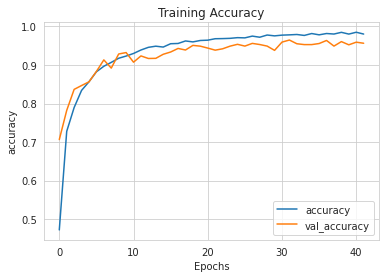

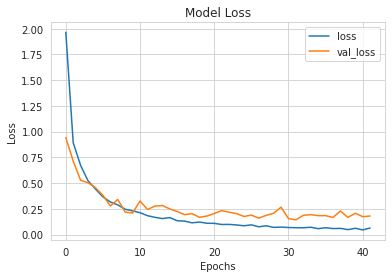

In [31]:
Acc_Loss_Graph(history)

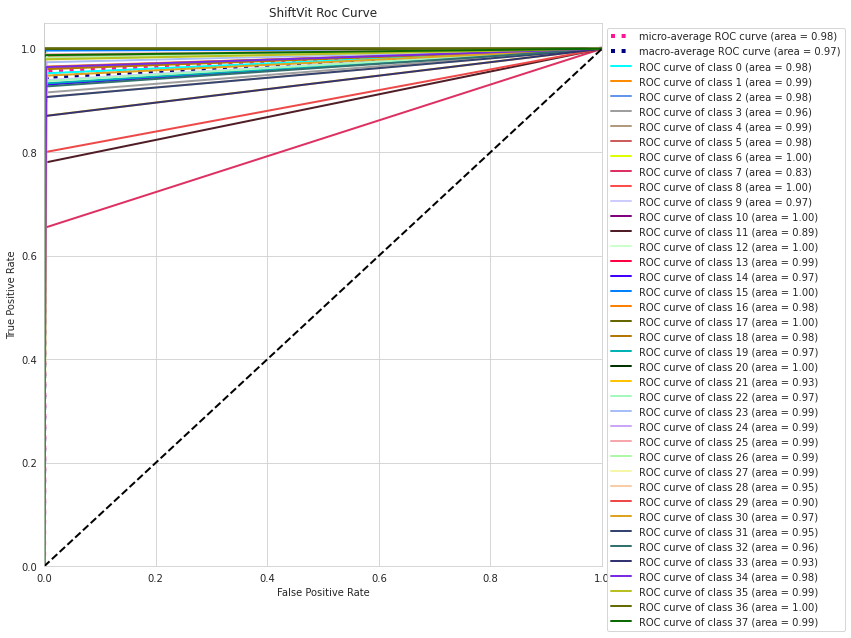

In [32]:
plot_roc_curve(y_test,y_pred2)

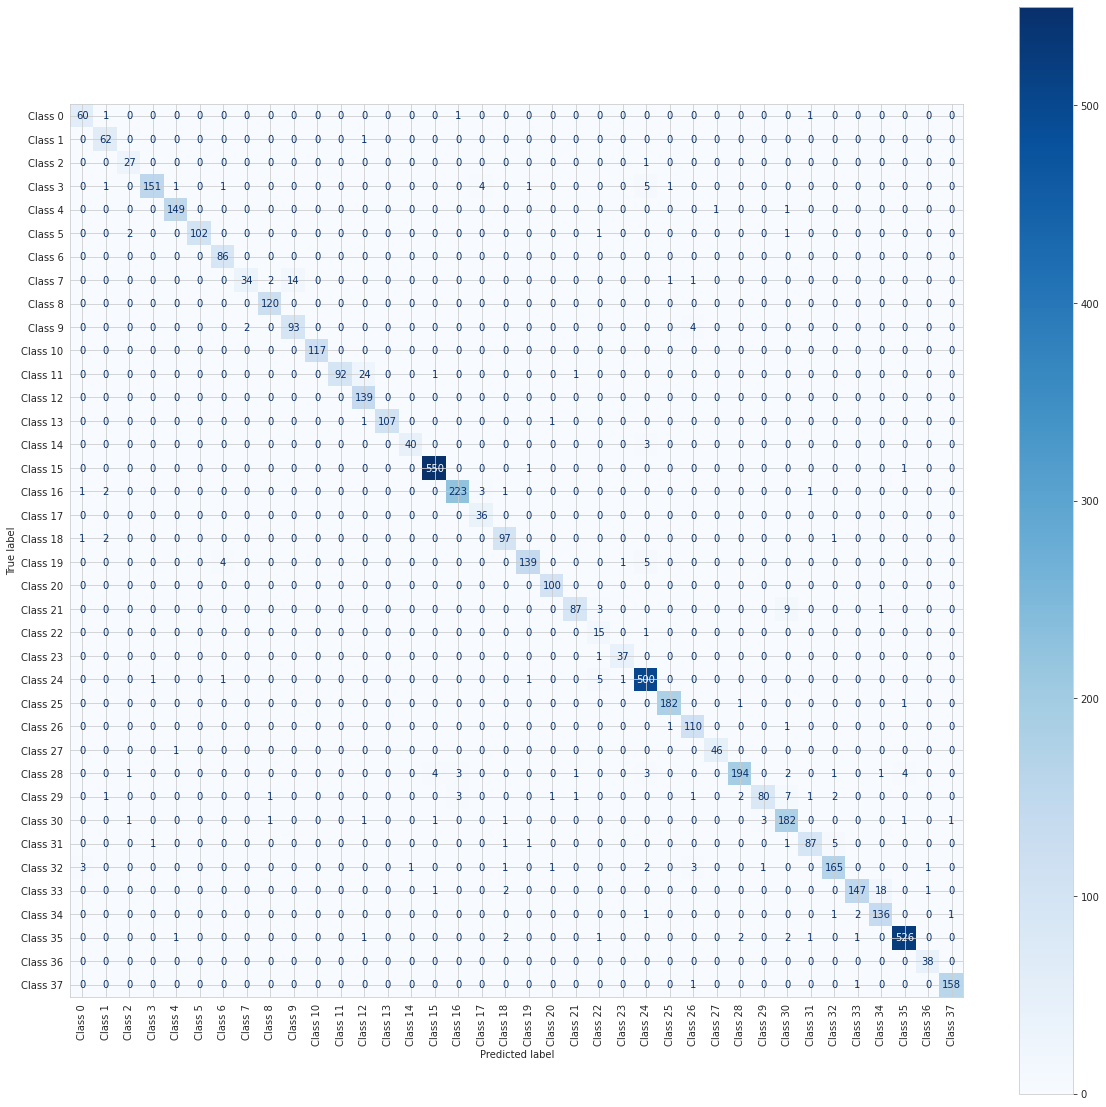

In [33]:
Confusion_Matrix(test_ds.classes , y_pred1)

In [36]:
from sklearn.manifold import TSNE
tsne1 = TSNE(random_state = 42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred)

In [37]:
# create dataframe
cps_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.column_stack((tsne1, 
                                            y_test1)))# cast targets column to int
cps_df.loc[:, 'target'] = cps_df.target.astype(int)
cps_df.loc[:, 'target'] = cps_df.target.map(target_name)

In [38]:
target_name={0:"Class 0",1:"Class 1",2:"Class 2",3:"Class 3",4:"Class 4",5:"Class 5",6:"Class 6",7:"Class 7",8:"Class 8",9:"Class 9",
             10:"Class 10",11:"Class 11",12:"Class 12",
               13:"Class 13",14:"Class 14",15:"Class 15",16:"Class 16",17:"Class 17",18:"Class 18",19:"Class 19",20:"Class 20",21:"Class 21",
             22:"Class 22",23:"Class 23",24:"Class 24",25:"Class 25",26:"Class 26",27:"Class 27",28:"Class 28",29:"Class 29",30:"Class 30",31:"Class 31",32:"Class 32",33:"Class 33",34:"Class 34"
                ,35:"Class 35",36:"Class 36",37:"Class 37"}

In [39]:
from sklearn.manifold import TSNE
tsne1 = TSNE(random_state = 42, n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(y_pred)

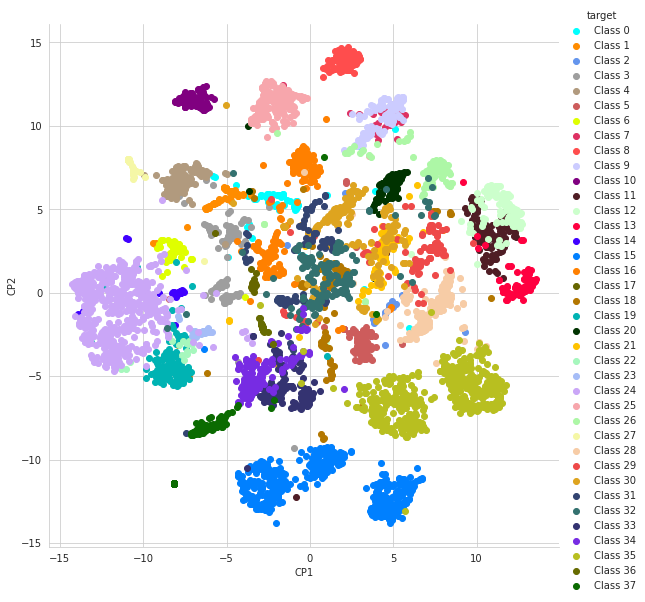

In [40]:
import seaborn as sns
d = {'color': ["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#CCCCFF','#800080','#4F1D25','#ccffcc','#ff0040'
                   ,'#4000ff','#0080ff','#ff8000','#666600','#b37700','#00b3b3','#003300','#FFC300','#A6F7BD',
                   '#A6BDF7','#CAA6F7','#F7A6AC','#ADF7A6','#F5F7A6','#F7CCA6','#EE4949',
                    '#DEA41F','#334471','#33716F','#343371','#772CE3','#B8BF20','#666B01','#0B6B01',
                    '#F4B708','#179690'] }
grid = sns.FacetGrid(cps_df, hue="target",hue_kws=d, height=8)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()

In [41]:
model.save_weights('/kaggle/working/model1.h5')